In [4]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2
from qiskit import QuantumCircuit , transpile
from qiskit_aer import AerSimulator
import pennylane as qml
from pennylane import numpy as np
import numpy as pop
SIZE = 256

img = cv2.imread( "/home/adminpc/Documents/Professors_Diary/QuantumnComputing/qenv/Qunatumcomputingalgos/Quantumn_image_classification/Images_for_classification/monalisa.jpg"
)

if img is None:
    raise ValueError("Image not found")
else :
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img_data = []
    img_data.append(pop.array(img)) # Using np.array instead of undefined img_to_array
    img_array = pop.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
    img_array = img_array.astype('float32')
    img_array /= 255.0
    flat = img_array.flatten() # flatten data array
    print("Image loaded and preprocessed successfully.")
    print(flat)

#qbt initilization
n_qubits = 15
n_layers = 20

features = flat[:n_qubits]

print("features" ,features)

inputs = (np.pi/4) * features

print({"Input of the qbits"} , inputs)
dev = qml.device("default.qubit", wires=n_qubits)

# Quantumn Circuit making
@qml.qnode(dev)
def qae(weights):

    # Encode data
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Variational layers
    for l in range(n_layers):
        for i in range(n_qubits):
            qml.RY(weights[l,i], wires=i)

        for i in range(0, n_qubits-1, 2):
            qml.CNOT(wires=[i, i+1])

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

## cost functions

def cost_fn(weights):
    output = qae(weights)
    return np.sum((1 - np.array(output))**2)

# assigning random weights 
weights = 0.01 * np.random.randn(n_layers, n_qubits, requires_grad=True)
opt = qml.AdamOptimizer(0.02) ## using adam optimazier one could also use other 

for step in range(200):
    weights = opt.step(cost_fn, weights)
    if step % 20 == 0:
        print("Step", step, "Cost", cost_fn(weights))

print("Optimized weights:", weights)
print(qae(weights))




Image loaded and preprocessed successfully.
[0.39607844 0.42745098 0.3647059  ... 0.27058825 0.25490198 0.32156864]
features [0.39607844 0.42745098 0.3647059  0.28627452 0.3254902  0.2509804
 0.38431373 0.44313726 0.34901962 0.35686275 0.43529412 0.32941177
 0.29411766 0.4        0.28627452]
{'Input of the qbits'} [0.3110793  0.33571923 0.28643936 0.2248395  0.2556394  0.19711955
 0.30183932 0.3480392  0.27411938 0.28027937 0.34187922 0.2587194
 0.23099947 0.31415927 0.2248395 ]
Step 0 Cost 0.005280178634402587
Step 20 Cost 0.000464611610881909
Step 40 Cost 6.580332965413241e-05
Step 60 Cost 4.408802098991595e-06
Step 80 Cost 3.5270769383509876e-07
Step 100 Cost 8.291181150534809e-08
Step 120 Cost 2.1262266512932194e-08
Step 140 Cost 8.565772157274395e-09
Step 160 Cost 4.641475300157476e-09
Step 180 Cost 2.892448169416533e-09
Optimized weights: [[-0.0102565  -0.01001062 -0.01115633 -0.0076774  -0.00980746 -0.02048926
  -0.02949286  0.00152261 -0.0269555  -0.00975185 -0.03612092 -0.0058

(1, 15)
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 7220.7168
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 7219.5342
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 7217.0283
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 7212.4321
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 7204.9473
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 7193.9990
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 7180.0918
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 7166.0425
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 7156.2178
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 7152.0811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


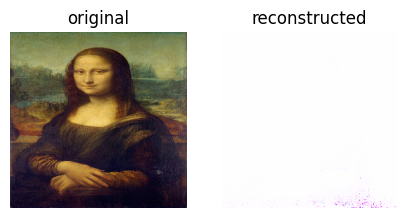

In [5]:
# Decoder part of program

from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

latent = qae(weights)
latent = np.array(latent).reshape(1, n_qubits)
print(latent.shape)
decoder = models.Sequential([
    layers.Input(shape=(n_qubits,)),
    layers.Dense(128, activation="relu"),
    #layers.BatchNormalization(),## OPtimizing batch layers
    layers.Dense(256, activation="relu"),
    #layers.BatchNormalization(),
    layers.Dense(512, activation="relu"),
    #layers.BatchNormalization(),
    layers.Dense(1024 , activation="relu"),
    #layers.BatchNormalization(),
    layers.Dense(256*256*3, activation="sigmoid"),
    layers.Reshape((256,256,3))
])
decoder.compile (optimizer = "adam" , loss = "mse")
decoder.fit(latent , img.reshape(1 , 256, 256 , 3) , epochs = 10, shuffle = True )
pred = decoder.predict(latent)

plt.figure(figsize =(5 , 5))
plt.subplot(1 ,2 ,1)
plt.title("original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1 ,2 ,2)
plt.title("reconstructed")
plt.imshow(pred[0])
plt.axis("off")
plt.show()
